/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_85290/3149766531.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_85290/3149766531.py:77: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_85290/3149766531.py:77: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_85290/3149766531.py:77: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.ti

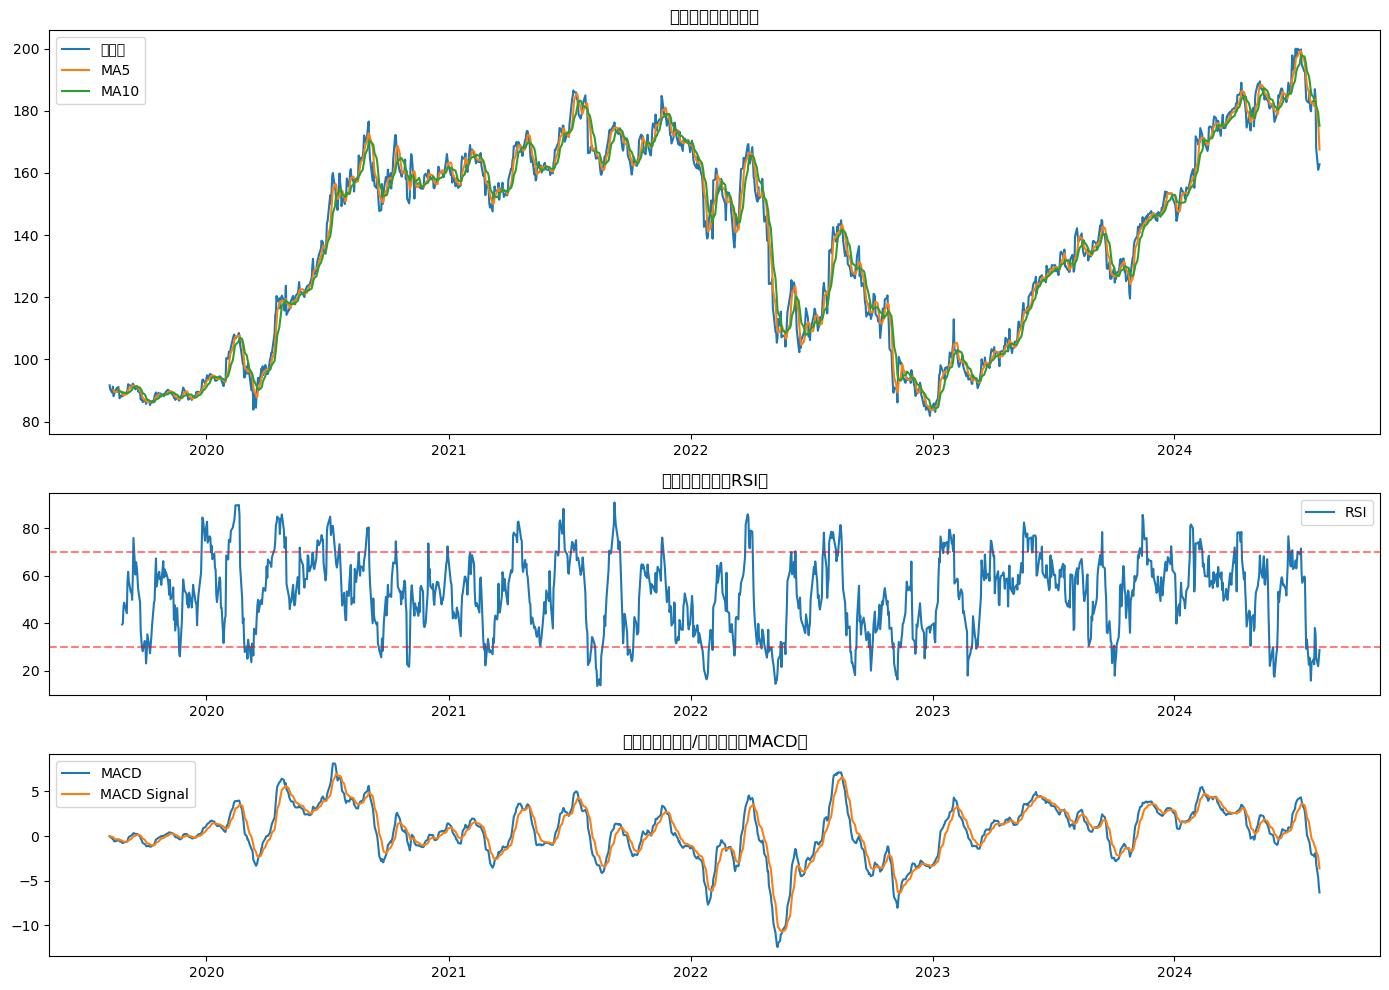

/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 28072 (\N{CJK UNIFIED IDEOGRAPH-6DA8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 36300 (\N{CJK UNIFIED IDEOGRAPH-8DCC}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 32929 (\N{CJK UNIFIED IDEOGRAPH-80A1}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 31080 (\N{CJK UNIFIED IDEOGRAPH-7968}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(b

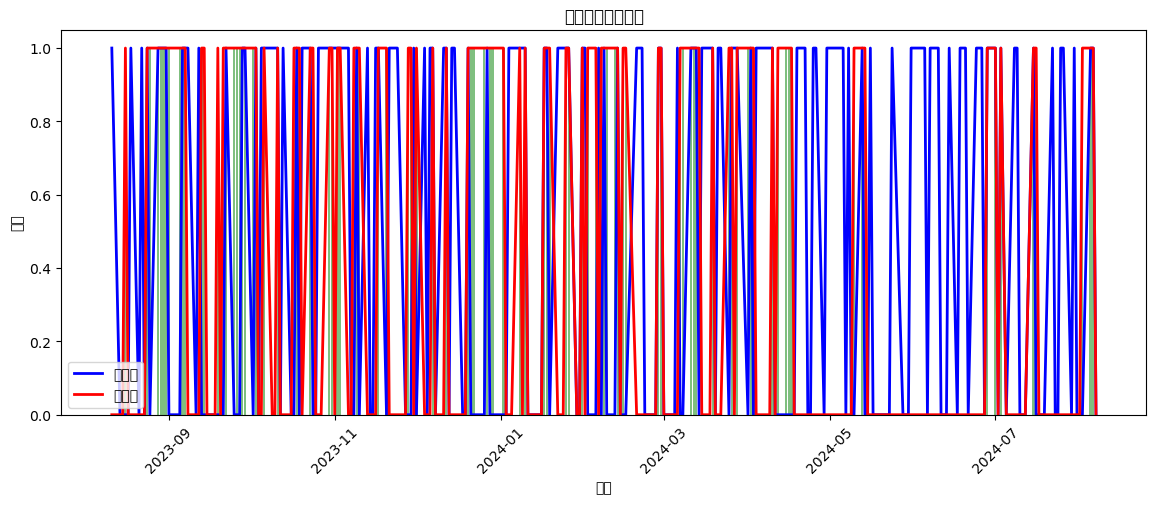

准确率: 0.4979919678714859


In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data.index

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制预测值和真实值的图像
def plot_predictions(dates, y_test, y_pred):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(dates, y_test, color='blue', lw=2, label='真实值')
    ax.plot(dates, y_pred, color='red', lw=2, label='预测值')

    for i in range(len(dates)):
        if y_pred[i] == 1:
            ax.bar(dates[i], y_pred[i], color='green', alpha=0.5)
        else:
            ax.bar(dates[i], y_pred[i], color='red', alpha=0.5)

    ax.set_title('股票价格涨跌预测')
    ax.set_xlabel('日期')
    ax.set_ylabel('涨跌')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 计算和打印准确度
def print_accuracy(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    print(f"准确率: {accuracy}")

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, dates = preprocess_data(data)

    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 创建XGBoost模型
    model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1)
    model.fit(x_train, y_train)

    # 进行预测
    predictions = model.predict(x_test)

    # 绘制技术指标图像
    plot_technical_indicators(data)

    # 绘制预测结果图像
    plot_predictions(dates[-len(y_test):], y_test, predictions)

    # 打印准确率
    print_accuracy(y_test, predictions)

if __name__ == '__main__':
    stock_code = input("请输入股票代码: ")
    main(stock_code)

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:76: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:76: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:76: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_

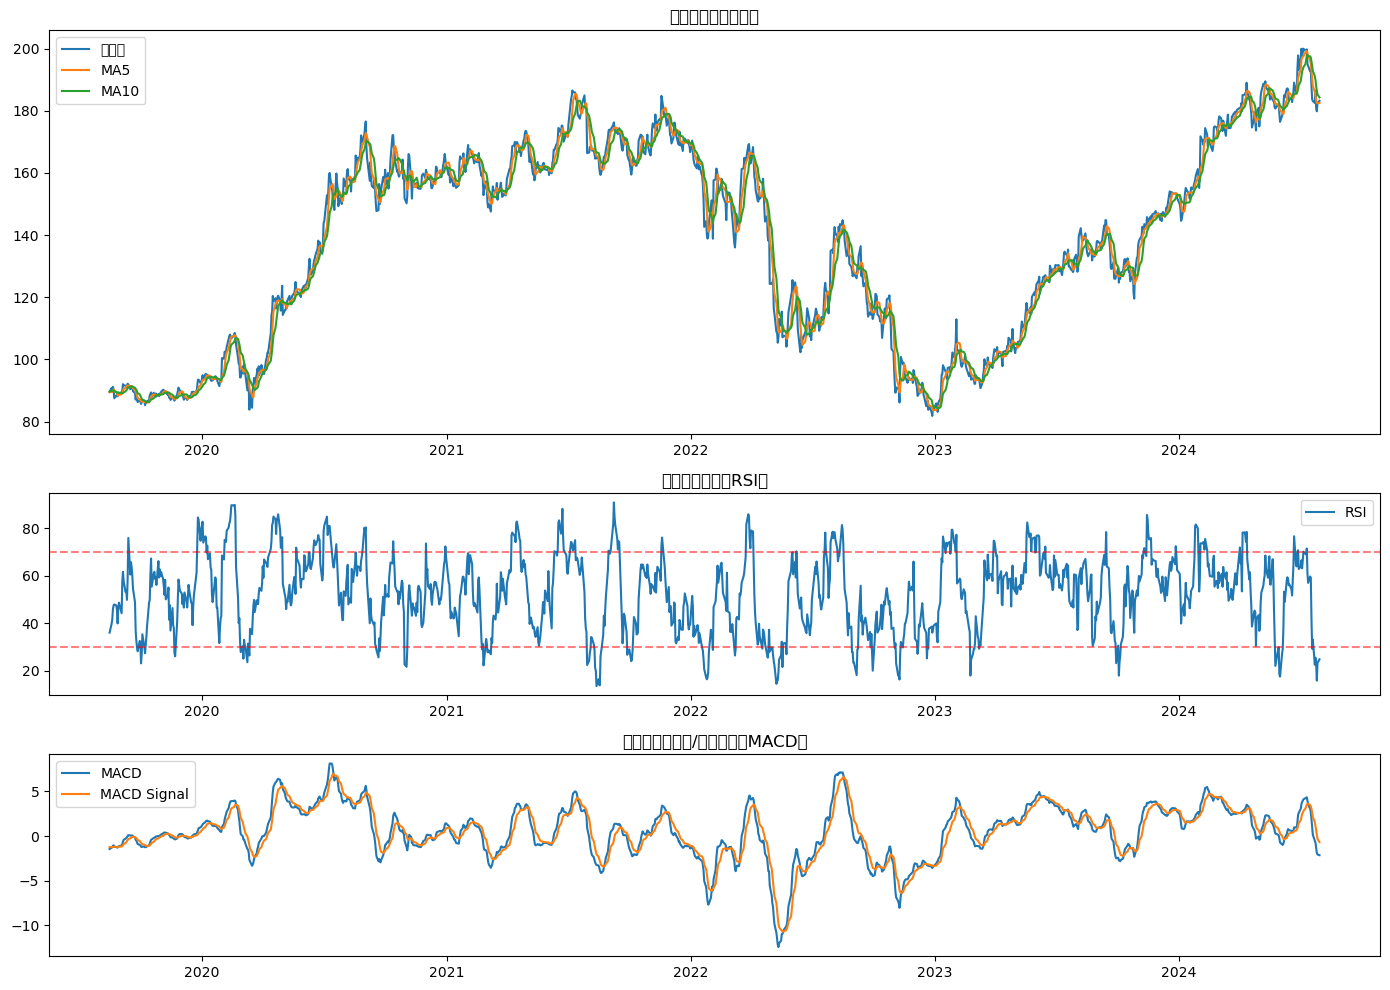

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/584060815.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

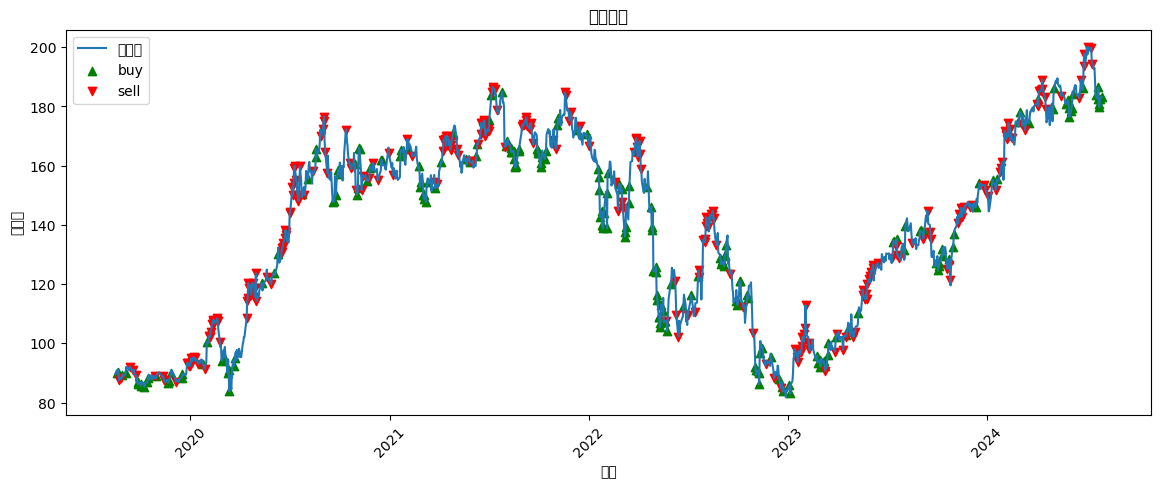

NameError: name 'accuracy_score' is not defined

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制交易信号
def plot_signals(data, buy_signals, sell_signals):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(data.index, data['Close'], label='收盘价')
    
    ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='buy', alpha=1)
    ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='sell', alpha=1)
    
    ax.set_title('交易信号')
    ax.set_xlabel('日期')
    ax.set_ylabel('收盘价')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 生成交易信号
def generate_signals(data):
    buy_signals = []
    sell_signals = []
    
    for i in range(1, len(data)):
        if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
            buy_signals.append(i)
        elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
            sell_signals.append(i)
        elif data['RSI'][i] < 30:
            buy_signals.append(i)
        elif data['RSI'][i] > 70:
            sell_signals.append(i)
        elif data['MACD'][i] > data['MACD_signal'][i] and data['MACD'][i-1] <= data['MACD_signal'][i-1]:
            buy_signals.append(i)
        elif data['MACD'][i] < data['MACD_signal'][i] and data['MACD'][i-1] >= data['MACD_signal'][i-1]:
            sell_signals.append(i)
    
    return buy_signals, sell_signals

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, full_data = preprocess_data(data)

    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 创建XGBoost模型
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(x_train, y_train)

    # 进行预测
    predictions = model.predict(x_test)

    # 绘制技术指标图像
    plot_technical_indicators(full_data)

    # 生成并绘制交易信号
    buy_signals, sell_signals = generate_signals(full_data)
    plot_signals(full_data, buy_signals, sell_signals)

    # 打印准确率
    accuracy = accuracy_score(y_test, predictions)
    print(f"准确率: {accuracy}")

if __name__ == '__main__':
    stock_code = "AMZN"
    main(stock_code)

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:76: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:76: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:76: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.ti

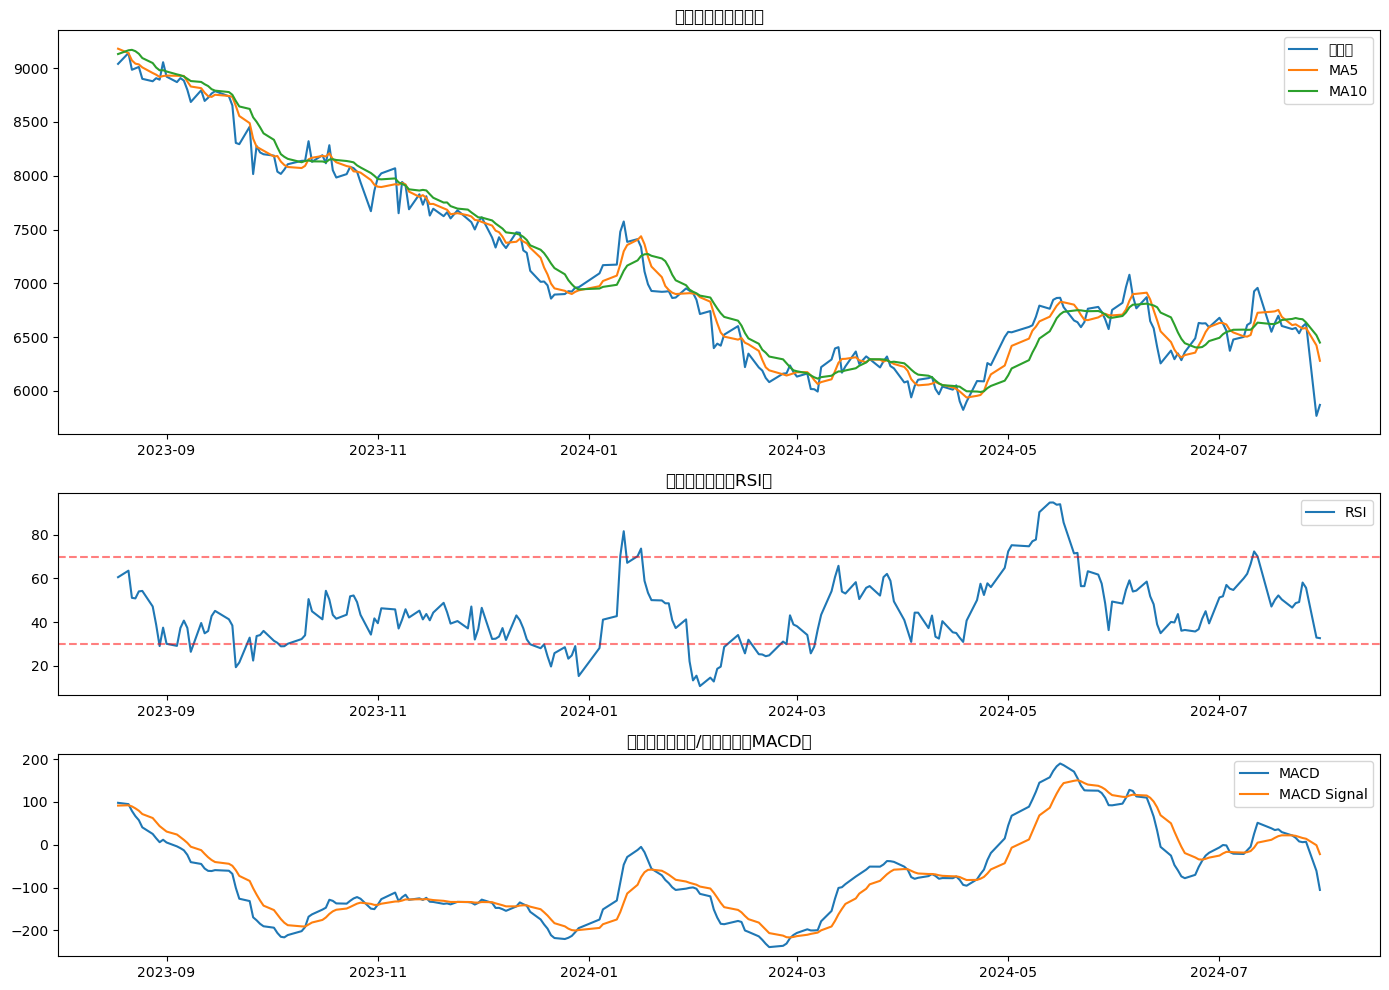

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:102: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:104: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

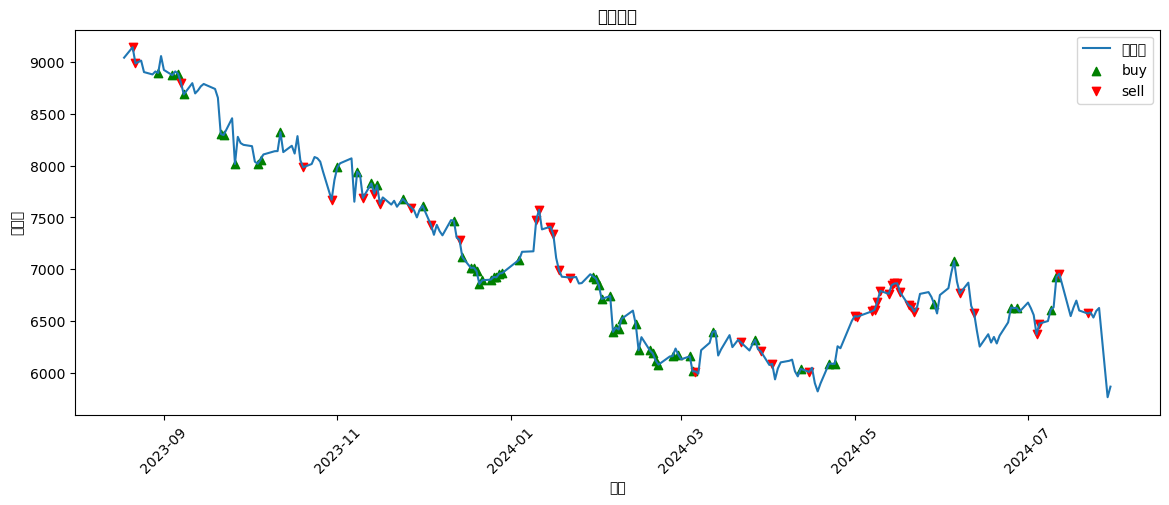

交易日志:
最终余额: 100000.0
总盈利: 0.0


/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/3267598657.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if balance >= 100 * data['Close'][i]:


In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='1y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制交易信号
def plot_signals(data, buy_signals, sell_signals):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(data.index, data['Close'], label='收盘价')
    
    ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='buy', alpha=1)
    ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='sell', alpha=1)
    
    ax.set_title('交易信号')
    ax.set_xlabel('日期')
    ax.set_ylabel('收盘价')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 交易信号
def generate_signals(data):
    buy_signals = []
    sell_signals = []
    
    for i in range(1, len(data)):
        if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
            buy_signals.append(i)
        elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
            sell_signals.append(i)
        elif data['RSI'][i] < 30:
            buy_signals.append(i)
        elif data['RSI'][i] > 70:
            sell_signals.append(i)
        elif data['MACD'][i] > data['MACD_signal'][i] and data['MACD'][i-1] <= data['MACD_signal'][i-1]:
            buy_signals.append(i)
        elif data['MACD'][i] < data['MACD_signal'][i] and data['MACD'][i-1] >= data['MACD_signal'][i-1]:
            sell_signals.append(i)
    
    return buy_signals, sell_signals

# 模拟交易
def simulate_trading(data, buy_signals, sell_signals):
    initial_balance = 100000  # 初始资金
    balance = initial_balance
    shares = 0
    trade_log = []

    for i in range(len(data)):
        if i in buy_signals:
            if balance >= 100 * data['Close'][i]:
                shares += 100
                balance -= 100 * data['Close'][i]
                trade_log.append((data.index[i], '买入', 100, data['Close'][i]))
        elif i in sell_signals:
            if shares >= 100:
                shares -= 100
                balance += 100 * data['Close'][i]
                trade_log.append((data.index[i], '卖出', 100, data['Close'][i]))

    # 计算最终余额
    final_balance = balance + shares * data['Close'].iloc[-1]
    profit = final_balance - initial_balance
    return trade_log, final_balance, profit

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, full_data = preprocess_data(data)

    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 创建XGBoost模型
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(x_train, y_train)

    # 进行预测
    predictions = model.predict(x_test)

    # 绘制技术指标图像
    plot_technical_indicators(full_data)

    # 生成并绘制交易信号
    buy_signals, sell_signals = generate_signals(full_data)
    plot_signals(full_data, buy_signals, sell_signals)

    # 模拟交易
    trade_log, final_balance, profit = simulate_trading(full_data, buy_signals, sell_signals)

    # 打印交易日志和盈利状况
    print("交易日志:")
    for log in trade_log:
        print(log)
    print(f"最终余额: {final_balance}")
    print(f"总盈利: {profit}")

if __name__ == '__main__':
    stock_code = input("请输入股票代码: ")
    main(stock_code)

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:77: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:77: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:77: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.ti

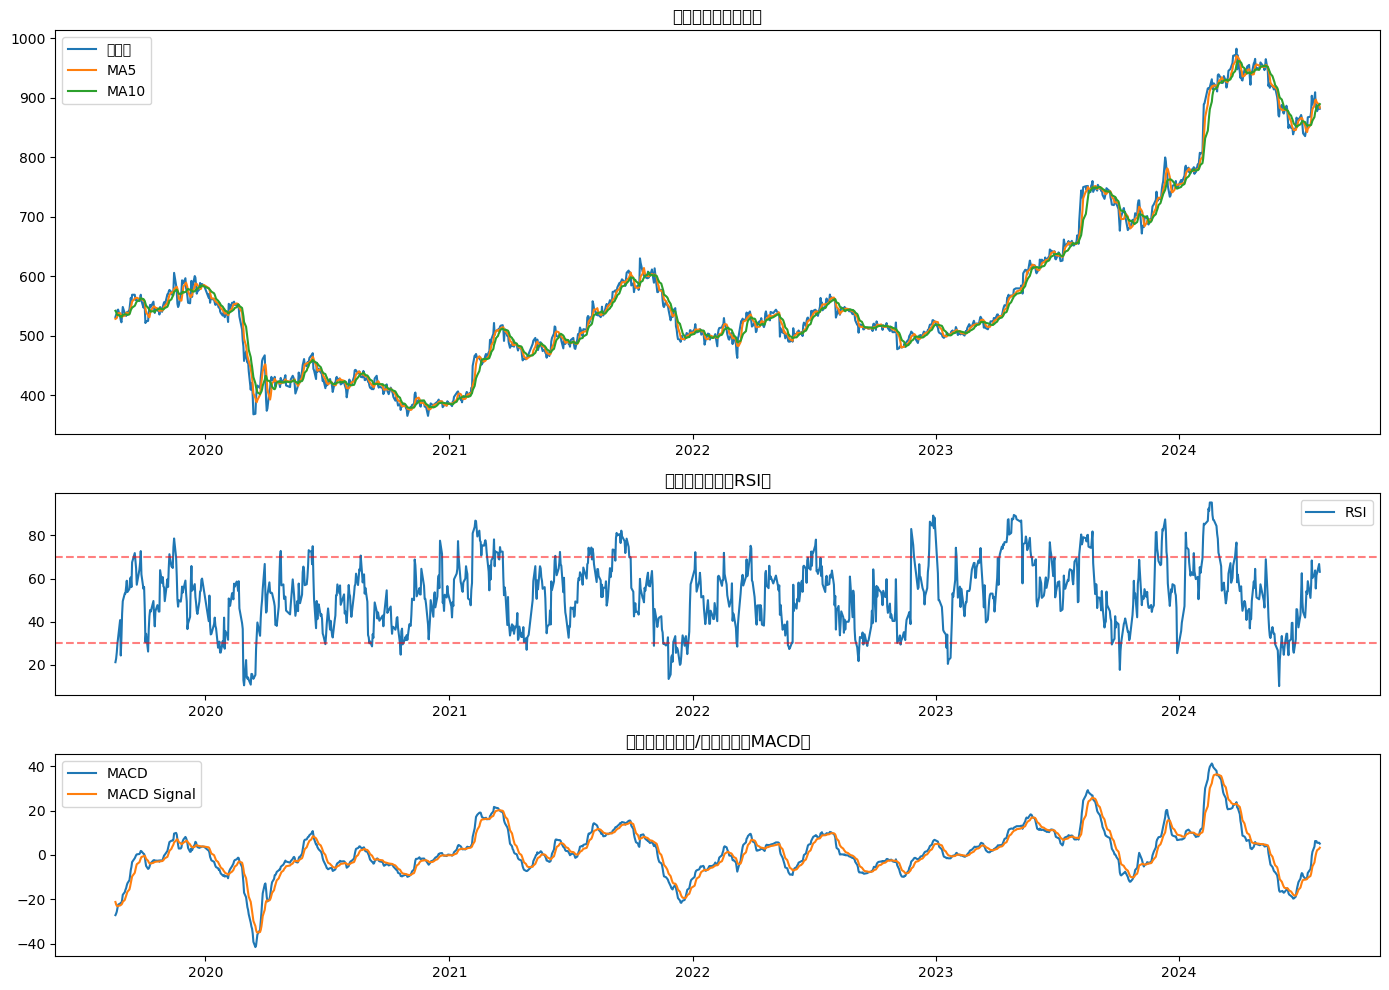

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:101: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:103: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:105: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alway

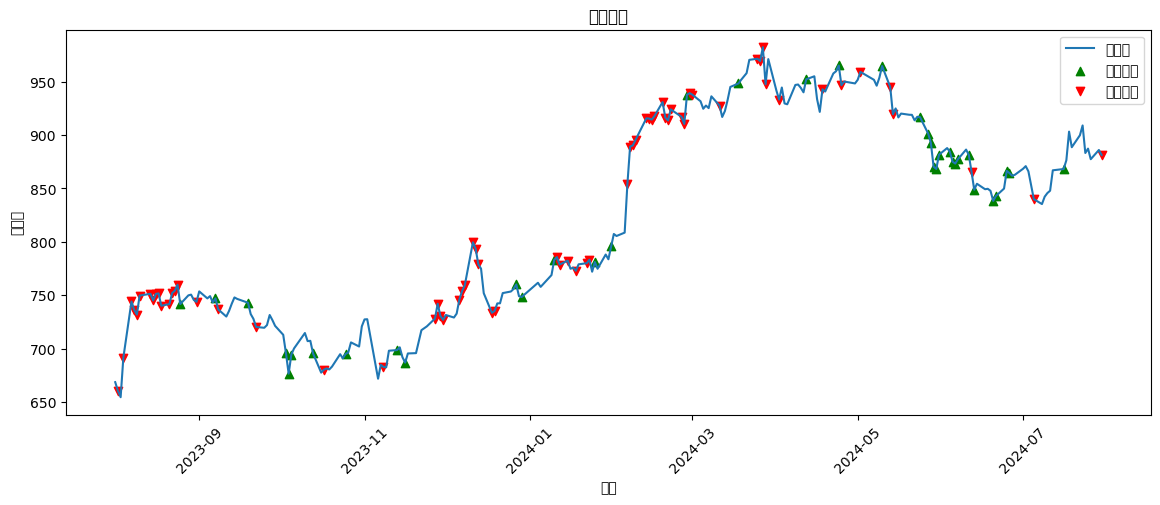

交易日志:
(Timestamp('2023-08-25 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 741.7871704101562)
(Timestamp('2023-08-31 00:00:00+0900', tz='Asia/Tokyo'), '卖出', 100, 743.9273681640625)
(Timestamp('2023-09-07 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 747.1377563476562)
(Timestamp('2023-09-08 00:00:00+0900', tz='Asia/Tokyo'), '卖出', 100, 736.8257446289062)
(Timestamp('2023-09-19 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 743.0518188476562)
(Timestamp('2023-09-22 00:00:00+0900', tz='Asia/Tokyo'), '卖出', 100, 720.384765625)
(Timestamp('2023-10-03 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 695.881103515625)
(Timestamp('2023-10-17 00:00:00+0900', tz='Asia/Tokyo'), '卖出', 100, 680.4017333984375)
(Timestamp('2023-10-25 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 695.0923461914062)
(Timestamp('2023-11-08 00:00:00+0900', tz='Asia/Tokyo'), '卖出', 100, 682.9652099609375)
(Timestamp('2023-11-13 00:00:00+0900', tz='Asia/Tokyo'), '买入', 100, 698.7403564453125)
(Timestamp('2023-11-27 00:00:00+0900', tz=

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:125: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if balance >= 100 * data['Close'][i]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:127: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance -= 100 * data['Close'][i]
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_28089/1877082723.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by positi

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制交易信号
def plot_signals(data, buy_signals, sell_signals):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(data.index, data['Close'], label='收盘价')
    
    ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='买入信号', alpha=1)
    ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='卖出信号', alpha=1)
    
    ax.set_title('交易信号')
    ax.set_xlabel('日期')
    ax.set_ylabel('收盘价')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 生成交易信号
def generate_signals(data):
    buy_signals = []
    sell_signals = []
    
    for i in range(1, len(data)):
        if data['MA5'][i] > data['MA10'][i] and data['MA5'][i-1] <= data['MA10'][i-1]:
            buy_signals.append(i)
        elif data['MA5'][i] < data['MA10'][i] and data['MA5'][i-1] >= data['MA10'][i-1]:
            sell_signals.append(i)
        elif data['RSI'][i] < 30:
            buy_signals.append(i)
        elif data['RSI'][i] > 70:
            sell_signals.append(i)
        elif data['MACD'][i] > data['MACD_signal'][i] and data['MACD'][i-1] <= data['MACD_signal'][i-1]:
            buy_signals.append(i)
        elif data['MACD'][i] < data['MACD_signal'][i] and data['MACD'][i-1] >= data['MACD_signal'][i-1]:
            sell_signals.append(i)
    
    return buy_signals, sell_signals

# 模拟交易
def simulate_trading(data, buy_signals, sell_signals):
    initial_balance = 100000  # 初始资金
    balance = initial_balance
    shares = 0
    trade_log = []

    for i in range(len(data)):
        if i in buy_signals:
            if balance >= 100 * data['Close'][i]:
                shares += 100
                balance -= 100 * data['Close'][i]
                trade_log.append((data.index[i], '买入', 100, data['Close'][i]))
        elif i in sell_signals:
            if shares >= 100:
                shares -= 100
                balance += 100 * data['Close'][i]
                trade_log.append((data.index[i], '卖出', 100, data['Close'][i]))

    # 计算最终余额
    final_balance = balance + shares * data['Close'].iloc[-1]
    profit = final_balance - initial_balance
    return trade_log, final_balance, profit

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, full_data = preprocess_data(data)

    # 使用最近一年的数据
    one_year_ago = pd.Timestamp.now().tz_localize('America/New_York') - pd.DateOffset(years=1)
    recent_data = full_data[full_data.index >= one_year_ago]

    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 创建XGBoost模型
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(x_train, y_train)

    # 进行预测
    predictions = model.predict(x_test)

    # 绘制技术指标图像
    plot_technical_indicators(full_data)

    # 生成并绘制交易信号
    buy_signals, sell_signals = generate_signals(recent_data)
    plot_signals(recent_data, buy_signals, sell_signals)

    # 模拟交易
    trade_log, final_balance, profit = simulate_trading(recent_data, buy_signals, sell_signals)

    # 打印交易日志和盈利状况
    print("交易日志:")
    for log in trade_log:
        print(log)
    print(f"最终余额: {final_balance}")
    print(f"总盈利: {profit}")

if __name__ == '__main__':
    stock_code = input("请输入股票代码: ")
    main(stock_code)

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:77: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:77: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:77: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layo

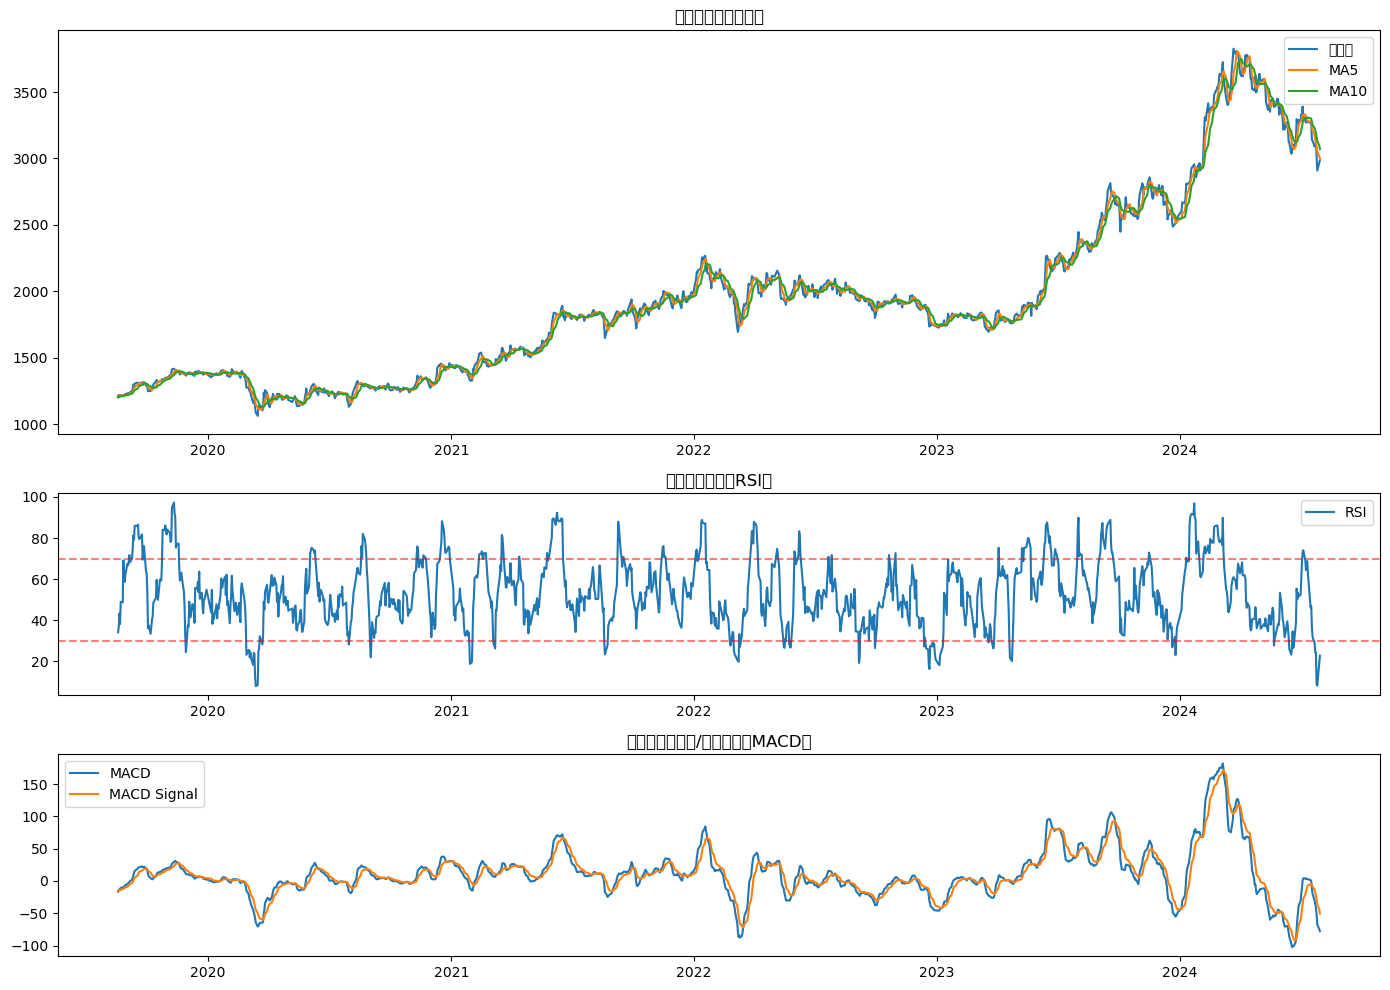

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:85: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='买入信号', alpha=1)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:86: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='卖出信号', alpha=1)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from c

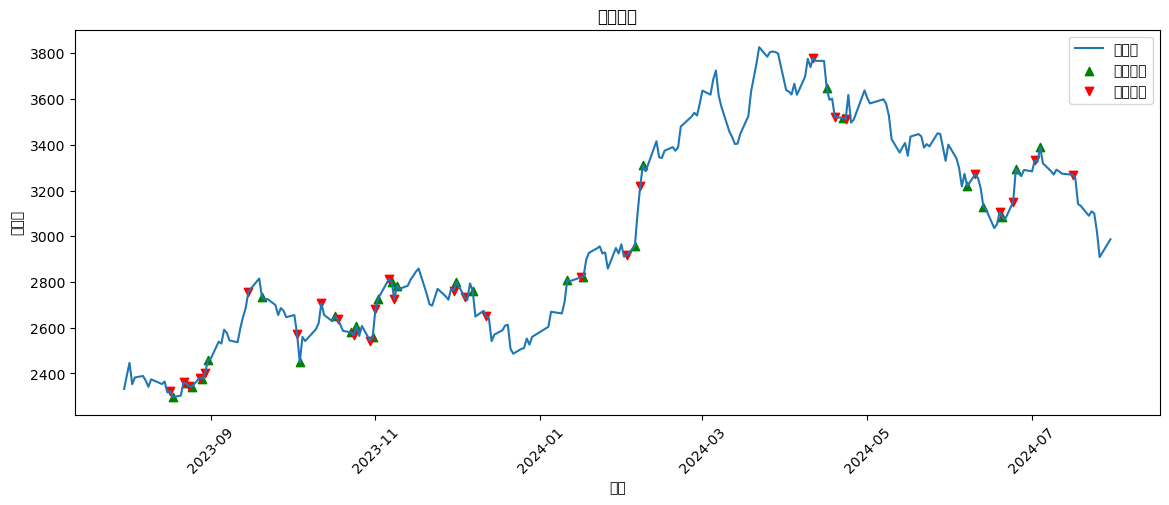

交易日志:
最终余额: 100000.0
总盈利: 0.0


/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/460114066.py:117: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if balance >= 100 * data['Close'][i]:


In [20]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制交易信号
def plot_signals(data, buy_signals, sell_signals):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(data.index, data['Close'], label='收盘价')
    
    ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='买入信号', alpha=1)
    ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='卖出信号', alpha=1)
    
    ax.set_title('交易信号')
    ax.set_xlabel('日期')
    ax.set_ylabel('收盘价')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 生成交易信号
def generate_signals(predictions):
    buy_signals = []
    sell_signals = []
    
    for i in range(1, len(predictions)):
        if predictions[i] == 1 and predictions[i-1] == 0:
            buy_signals.append(i)
        elif predictions[i] == 0 and predictions[i-1] == 1:
            sell_signals.append(i)
    
    return buy_signals, sell_signals

# 模拟交易
def simulate_trading(data, buy_signals, sell_signals):
    initial_balance = 100000  # 初始资金
    balance = initial_balance
    shares = 0
    trade_log = []

    for i in range(len(data)):
        if i in buy_signals:
            if balance >= 100 * data['Close'][i]:
                shares += 100
                balance -= 100 * data['Close'][i]
                trade_log.append((data.index[i], '买入', 100, data['Close'][i]))
        elif i in sell_signals:
            if shares >= 100:
                shares -= 100
                balance += 100 * data['Close'][i]
                trade_log.append((data.index[i], '卖出', 100, data['Close'][i]))

    # 计算最终余额
    final_balance = balance + shares * data['Close'].iloc[-1]
    profit = final_balance - initial_balance
    return trade_log, final_balance, profit

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, full_data = preprocess_data(data)

    # 使用最近一年的数据
    one_year_ago = pd.Timestamp.now().tz_localize('America/New_York') - pd.DateOffset(years=1)
    recent_data = full_data[full_data.index >= one_year_ago]
    recent_features = features[full_data.index >= one_year_ago]
    recent_target = target[full_data.index >= one_year_ago]

    # 分割训练集和测试集
    x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=False)

    # 创建XGBoost模型
    model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1)
    model.fit(x_train, y_train)

    # 对最近一年的数据进行预测
    recent_predictions = model.predict(recent_features)

    # 绘制技术指标图像
    plot_technical_indicators(full_data)

    # 生成并绘制交易信号
    buy_signals, sell_signals = generate_signals(recent_predictions)
    plot_signals(recent_data, buy_signals, sell_signals)

    # 模拟交易
    trade_log, final_balance, profit = simulate_trading(recent_data, buy_signals, sell_signals)

    # 打印交易日志和盈利状况
    print("交易日志:")
    for log in trade_log:
        print(log)
    print(f"最终余额: {final_balance}")
    print(f"总盈利: {profit}")

if __name__ == '__main__':
    stock_code = input("请输入股票代码: ")
    main(stock_code)

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)


Epoch 1/20


2024-07-30 10:25:59.399704: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


30/30 [==============================] - 7s 104ms/step - loss: 0.6970 - accuracy: 0.5195 - val_loss: 0.6935 - val_accuracy: 0.5105
Epoch 2/20
30/30 [==============================] - 1s 22ms/step - loss: 0.6972 - accuracy: 0.4963 - val_loss: 0.6955 - val_accuracy: 0.4810
Epoch 3/20
30/30 [==============================] - 1s 23ms/step - loss: 0.6944 - accuracy: 0.5005 - val_loss: 0.6926 - val_accuracy: 0.5190
Epoch 4/20
30/30 [==============================] - 1s 23ms/step - loss: 0.6944 - accuracy: 0.5238 - val_loss: 0.6920 - val_accuracy: 0.5443
Epoch 5/20
30/30 [==============================] - 1s 21ms/step - loss: 0.6928 - accuracy: 0.5016 - val_loss: 0.6921 - val_accuracy: 0.5148
Epoch 6/20
30/30 [==============================] - 1s 23ms/step - loss: 0.6921 - accuracy: 0.5333 - val_loss: 0.6928 - val_accuracy: 0.5021
Epoch 7/20
30/30 [==============================] - 1s 23ms/step - loss: 0.6915 - accuracy: 0.5269 - val_loss: 0.6956 - val_accuracy: 0.4810
Epoch 8/20
30/30 [=====

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:91: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:91: UserWarning: Glyph 30424 (\N{CJK UNIFIED IDEOGRAPH-76D8}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:91: UserWarning: Glyph 20215 (\N{CJK UNIFIED IDEOGRAPH-4EF7}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:91: UserWarning: Glyph 19982 (\N{CJK UNIFIED IDEOGRAPH-4E0E}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:91: UserWarning: Glyph 31227 (\N{CJK UNIFIED IDEOGRAPH-79FB}) missing from current font.
  plt.tight_layout()
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7

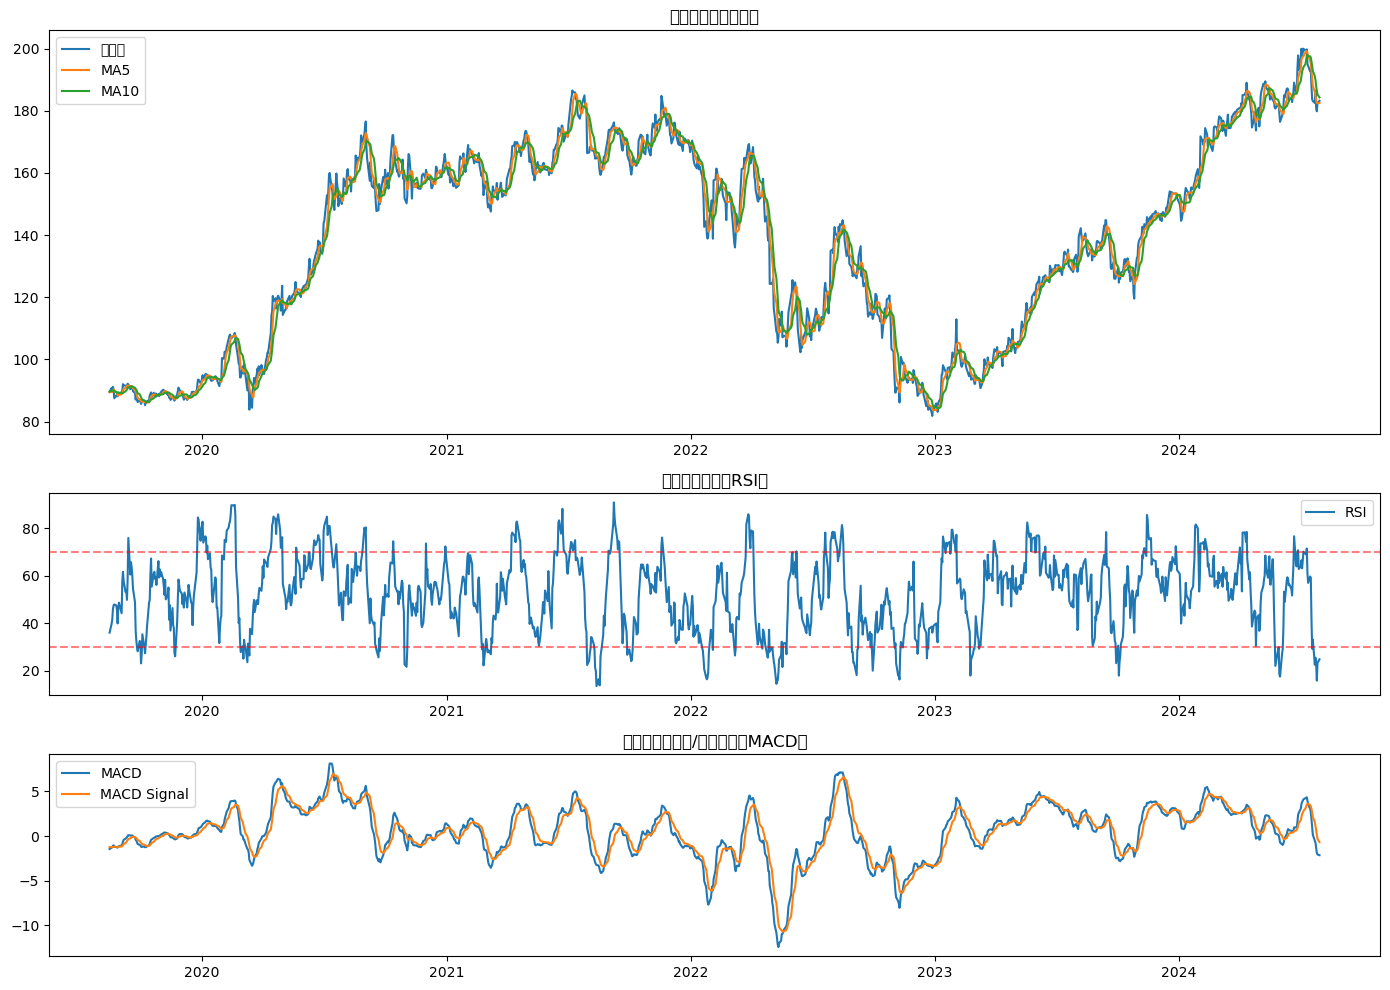

/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='买入信号', alpha=1)
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:100: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='卖出信号', alpha=1)
/opt/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25910 (\N{CJK UNIFIED IDEOGRAPH-6536}) missing fro

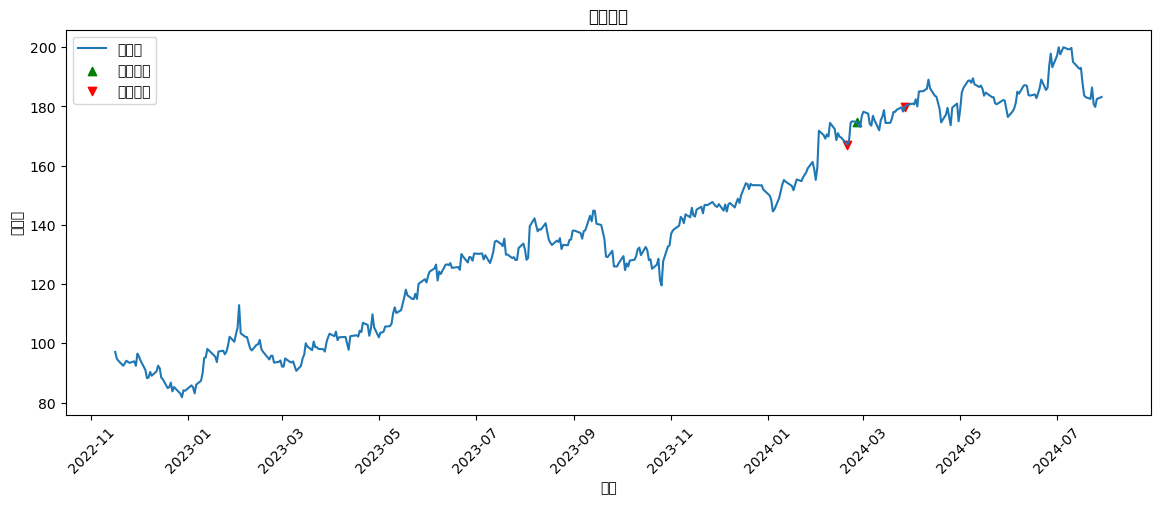

交易日志:
(Timestamp('2024-05-21 00:00:00-0400', tz='America/New_York'), '买入', 100, 183.14999389648438)
最终余额: 100242.00134277344
总盈利: 242.0013427734375
(Timestamp('2024-06-24 00:00:00-0400', tz='America/New_York'), '卖出', 100, 185.57000732421875)
最终余额: 100242.00134277344
总盈利: 242.0013427734375


/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if balance >= 100 * data['Close'][i]:
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:133: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  balance -= 100 * data['Close'][i]
/var/folders/q7/54zdqqsd2k97cjf5y4lqxf_00000gn/T/ipykernel_7681/3697913100.py:134: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta

# 获取股票数据
def get_stock_data(stock_code):
    stock = yf.Ticker(stock_code)
    data = stock.history(period='5y')
    return data

# 计算技术指标
def add_technical_indicators(data):
    data['MA5'] = data['Close'].rolling(window=5).mean()
    data['MA10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = compute_rsi(data['Close'], 14)
    data['MACD'], data['MACD_signal'] = compute_macd(data['Close'])
    data = data.dropna()
    return data

# 计算相对强弱指数（RSI）
def compute_rsi(series, period):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# 计算移动平均线收敛/发散指标（MACD）
def compute_macd(series, short_window=12, long_window=26, signal_window=9):
    short_ema = series.ewm(span=short_window, adjust=False).mean()
    long_ema = series.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

# 预处理数据
def preprocess_data(data):
    data = add_technical_indicators(data)
    data['Target'] = np.where(data['Close'].shift(-1) > data['Close'], 1, 0)
    data = data.dropna()
    features = data[['Open', 'High', 'Low', 'Close', 'MA5', 'MA10', 'RSI', 'MACD', 'MACD_signal']]
    target = data['Target']
    return features, target, data

# 创建LSTM模型
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 绘制技术指标图像
def plot_technical_indicators(data):
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(3, 1, height_ratios=[2, 1, 1])
    
    ax0 = plt.subplot(gs[0])
    ax0.plot(data.index, data['Close'], label='收盘价')
    ax0.plot(data.index, data['MA5'], label='MA5')
    ax0.plot(data.index, data['MA10'], label='MA10')
    ax0.set_title('收盘价与移动平均线')
    ax0.legend()
    
    ax1 = plt.subplot(gs[1], sharex=ax0)
    ax1.plot(data.index, data['RSI'], label='RSI')
    ax1.axhline(70, linestyle='--', alpha=0.5, color='r')
    ax1.axhline(30, linestyle='--', alpha=0.5, color='r')
    ax1.set_title('相对强弱指数（RSI）')
    ax1.legend()

    ax2 = plt.subplot(gs[2], sharex=ax0)
    ax2.plot(data.index, data['MACD'], label='MACD')
    ax2.plot(data.index, data['MACD_signal'], label='MACD Signal')
    ax2.set_title('移动平均线收敛/发散指标（MACD）')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# 绘制交易信号
def plot_signals(data, buy_signals, sell_signals):
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(data.index, data['Close'], label='收盘价')
    
    ax.scatter(data.index[buy_signals], data['Close'][buy_signals], marker='^', color='g', label='买入信号', alpha=1)
    ax.scatter(data.index[sell_signals], data['Close'][sell_signals], marker='v', color='r', label='卖出信号', alpha=1)
    
    ax.set_title('交易信号')
    ax.set_xlabel('日期')
    ax.set_ylabel('收盘价')
    ax.legend()
    plt.xticks(rotation=45)
    plt.show()

# 生成交易信号
def generate_signals(predictions):
    buy_signals = []
    sell_signals = []
    
    for i in range(1, len(predictions)):
        if predictions[i] > 0.5 and predictions[i-1] <= 0.5:
            buy_signals.append(i)
        elif predictions[i] <= 0.5 and predictions[i-1] > 0.5:
            sell_signals.append(i)
    
    return buy_signals, sell_signals

# 模拟交易
def simulate_trading(data, buy_signals, sell_signals):
    initial_balance = 100000  # 初始资金
    balance = initial_balance
    shares = 0
    trade_log = []

    for i in range(len(data)):
        if i in buy_signals:
            if balance >= 100 * data['Close'][i]:
                shares += 100
                balance -= 100 * data['Close'][i]
                trade_log.append((data.index[i], '买入', 100, data['Close'][i]))
        elif i in sell_signals:
            if shares >= 100:
                shares -= 100
                balance += 100 * data['Close'][i]
                trade_log.append((data.index[i], '卖出', 100, data['Close'][i]))

    # 计算最终余额
    final_balance = balance + shares * data['Close'].iloc[-1]
    profit = final_balance - initial_balance
    return trade_log, final_balance, profit

def main(stock_code):
    data = get_stock_data(stock_code)
    features, target, full_data = preprocess_data(data)

    # 标准化特征数据
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler.fit_transform(features)

    # 创建时间步数据
    def create_dataset(data, time_step=1):
        x, y = [], []
        for i in range(len(data)-time_step-1):
            a = data[i:(i+time_step), :]
            x.append(a)
            y.append(target.values[i + time_step])
        return np.array(x), np.array(y)

    time_step = 60
    x, y = create_dataset(scaled_features, time_step)

    # 分割训练集和测试集
    train_size = int(len(x) * 0.8)
    x_train, x_test = x[0:train_size], x[train_size:]
    y_train, y_test = y[0:train_size], y[train_size:]

    # 创建LSTM模型
    model = create_lstm_model((time_step, x.shape[2]))
    model.fit(x_train, y_train, epochs=20, batch_size=32, validation_data=(x_test, y_test), verbose=1)

    # 对最近一年的数据进行预测
    recent_data = full_data.iloc[-(365+time_step):]  # 使用最近一年的数据
    recent_features = scaled_features[-(365+time_step):]
    x_recent, _ = create_dataset(recent_features, time_step)
    recent_predictions = model.predict(x_recent)
    recent_predictions = np.where(recent_predictions > 0.5, 1, 0).flatten()

    # 绘制技术指标图像
    plot_technical_indicators(full_data)

    # 生成并绘制交易信号
    buy_signals, sell_signals = generate_signals(recent_predictions)
    plot_signals(recent_data, buy_signals, sell_signals)

    # 模拟交易
    trade_log, final_balance, profit = simulate_trading(recent_data.iloc[time_step:], buy_signals, sell_signals)

    # 打印交易日志和盈利状况
    print("交易日志:")
    for log in trade_log:
        print(log)
        print(f"最终余额: {final_balance}")
        print(f"总盈利: {profit}")
        
if __name__ == '__main__':
    stock_code = input("请输入股票代码: ")
    main(stock_code)